# Chart election winner at sportsbet

## Python set-up

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import plotting

In [3]:
plt.style.use("fivethirtyeight")
LFOOTER = "Betting odds observed periodically at sportsbet.com.au."
footers = plotting.footers | {"lfooter": LFOOTER}
SHOW = True

## Get data

In [4]:
FILE = "../betting-data/sportsbet-2025-election-winner.csv"
data = pd.read_csv(FILE, index_col=0, header=0, skiprows=None)
data = (
    data.pivot(columns="Party")
    .droplevel(level=0, axis=1)  # remove hierarchical column index
    .drop("Any Other Party", axis=1)  # ignore long-shot bias
)
data.tail()

Party,Coalition,Labor
Datetime,,
2023-12-11 11:57:08.699031,2.1,1.75
2023-12-12 11:57:09.796506,2.0,1.85
2023-12-13 11:57:13.173706,2.0,1.85
2023-12-14 11:57:16.327679,2.0,1.85
2023-12-15 11:57:13.606614,2.0,1.85


## Make some charts

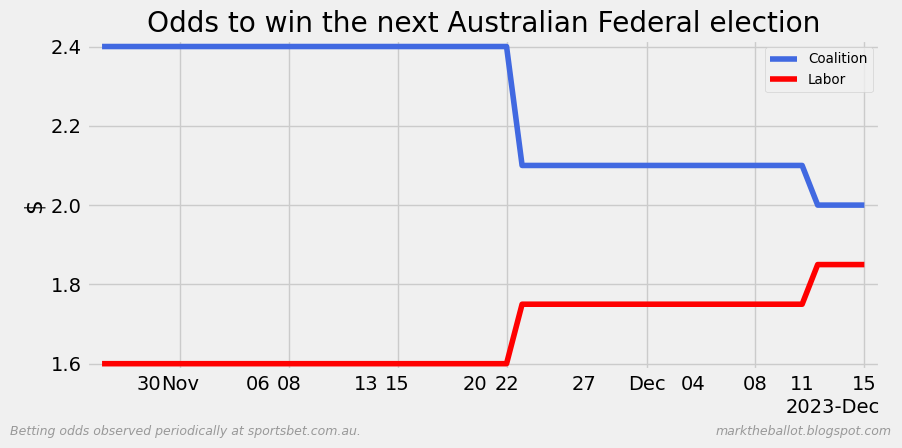

In [5]:
data.index = pd.PeriodIndex(data.index, freq="D")
colors = plotting.colorise(data.columns)
ax = None
for column, color in zip(data.columns, colors):
    ax = data[column].plot.line(color=color, ax=ax)
plotting.finalise_plot(
    ax,
    title="Odds to win the next Australian Federal election",
    xlabel=None,
    ylabel="$",
    legend=plotting.LEGEND_SET,
    concise_dates=True,
    **footers,
    show=SHOW,
)

In [6]:
def convert(odds: pd.DataFrame) -> pd.DataFrame:
    # get raw probabilities
    raw_probs = 1 / odds

    # remove the bookmakers over-round
    total = raw_probs.sum(axis=1)
    adj_probs = raw_probs.div(total, axis=0)

    return adj_probs

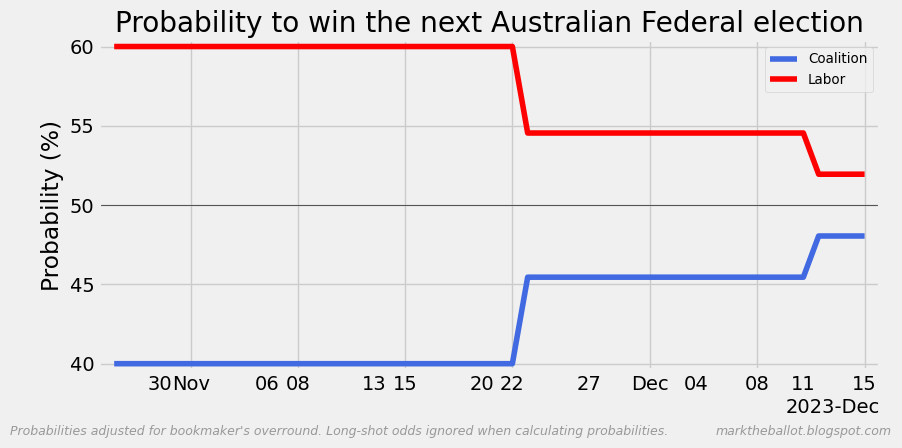

In [7]:
adj_probs = convert(data) * 100
ax = None
for column, color in zip(adj_probs.columns, colors):
    ax = adj_probs[column].plot.line(color=color, ax=ax)

LFOOTER = (
    "Probabilities adjusted for bookmaker's overround. "
    "Long-shot odds ignored when calculating probabilities. "
)

plotting.finalise_plot(
    ax,
    title="Probability to win the next Australian Federal election",
    xlabel=None,
    ylabel="Probability (%)",
    legend=plotting.LEGEND_SET,
    concise_dates=True,
    y50=True,
    rfooter=plotting.RFOOTER,
    lfooter=LFOOTER,
    show=SHOW,
)

## Finished

In [8]:
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Fri Dec 15 2023 17:22:34

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.18.1

pandas    : 2.1.3
matplotlib: 3.8.2

Watermark: 2.4.3



In [9]:
print("It is done")

It is done
